<a href="https://colab.research.google.com/github/J0KERtry/python_repository/blob/main/%E5%AE%9F%E5%8A%9B%E3%83%86%E3%82%B9%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なものを準備

In [ ]:
!pip install -q pytorch_lightning
!pip install -q torchmetrics

     |████████████████████████████████| 527 kB 7.2 MB/s 
     |████████████████████████████████| 397 kB 18.0 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 133 kB 49.3 MB/s 
     |████████████████████████████████| 952 kB 43.1 MB/s 
     |████████████████████████████████| 829 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 271 kB 43.6 MB/s 
     |████████████████████████████████| 144 kB 47.3 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchmetrics.functional import accuracy
%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 8, 6
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [ ]:
# train, testデータの取得
path = '/content/bank_train.csv'
path_t = '/content/bank_test02.csv'
train = pd.read_csv(path)
test = pd.read_csv(path_t)
train.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,entrepreneur,married,secondary,no,1857,no,yes,-1.0,0,unknown,fail
1,37.0,technician,single,secondary,no,363,yes,no,-1.0,0,unknown,fail
2,35.0,blue-collar,married,primary,no,422,yes,no,-1.0,0,unknown,fail


# **データの前処理**

前処理の流れ
1.   重複行の削除

2.   欠損値の処理
 - age　<-　平均値で補完
 - default　<-　最頻値で補完
 - pdays　<-　最頻値で補完


3.   特徴量エンジニアリング
 1. job の 欠損値を unknown と変換
 2. job を職種別に分類

4.   外れ値除去
 - default の外れ値を除去　(3σ法)

5. カテゴリカル変数の処理
 - One-Hot-Encoding ( job, education以外 )
 - Label-Encoding ( job, education )



## **1.　重複行の削除**

In [ ]:
# train の重複行を確認
print(train.duplicated(keep=False).value_counts())

False    6357
True       59
dtype: int64


In [ ]:
# train の重複行を削除
train = train.drop_duplicates()
train.shape

(6384, 12)

## **2.　欠損値の処理**

In [ ]:
# train, test の欠損値を確認
print('train の欠損値')
print(train.isnull().sum()) 
print('-------------------------')
print('test の欠損値')
print(test.isnull().sum())

train の欠損値
age           90
job            3
marital       89
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64
-------------------------
test の欠損値
age           35
job            8
marital       45
education      0
default       62
balance        0
housing      114
loan          24
pdays         79
previous       0
poutcome     152
result         0
dtype: int64


### age

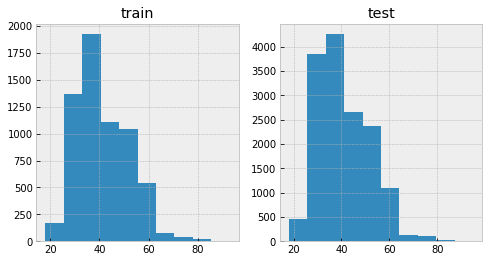

In [ ]:
# age の分布を可視化
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.hist(train['age'])
plt.title('train')

plt.subplot(1,2,2)
plt.hist(test['age'])
plt.title('test')
plt.show()

In [ ]:
# 'age' の代表値を確認
print('train[age] の平均値, 中央値:',' ', train['age'].mean(), ' ', train['age'].median())
print('test[age] の平均値, 中央値:','  ', test['age'].mean(),' ', test['age'].median())

train[age] の平均値, 中央値:   40.99555131871624   39.0
test[age] の平均値, 中央値:    40.95770130304043   39.0


In [ ]:
# age の欠損値を平均値で補完
train = train.fillna({'age': int(train['age'].mean())})
test = test.fillna({'age': int(test['age'].mean())})

### default

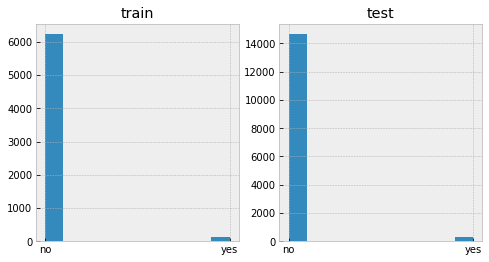

In [ ]:
# default の分布を可視化
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
train['default'].hist();
plt.title('train')

plt.subplot(1,2,2)
test['default'].hist();
plt.title('test')
plt.show()

In [ ]:
# default の欠損値を no で補完
train = train.fillna({'default': 'no'})
test = test.fillna({'default': 'no'})

### pdays

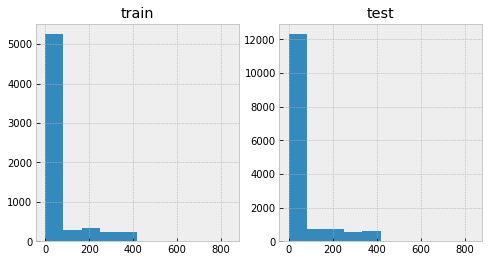

In [ ]:
# pdays の分布を可視化
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.hist(train['pdays'])
plt.title('train')

plt.subplot(1,2,2)
plt.hist(test['pdays'])
plt.title('test')
plt.show()

In [ ]:
# pdays の欠損値を最頻値で補完
train = train.fillna({'pdays': train['pdays'].mode()[0]})
test = test.fillna({'pdays': test['pdays'].mode()[0]})

## **3.　特徴量エンジニアリング**
以下の職業でクラス分け
0. blue-collar　＜ 現場作業 ＞
1. services   　　＜ サービス業 ＞
2. technician 　＜ 技術者 ＞
3. management, admin　　＜ 管理者 ＞
4. entrepreneur, self-employed   　＜ 自営業 ＞
5. housemaid　＜ 家政婦 ＞
6. retired, unemployed, student    　＜収入源無し＞
7. unknown, NaN　＜情報なし＞

In [ ]:
# 'job' の欠損値を 'unknown' と分類
train.loc[train['job'].isna(), 'job'] = 'unknown'
test.loc[test['job'].isna(), 'job'] = 'unknown'

In [ ]:
# クラス分けの定義
class_0 = ['blue-collar']
class_1 = ['services']
class_2 = ['technician']
class_3 = ['management', 'admin.']
class_4 = ['entrepreneur', 'self-employed']
class_5 = ['housemaid']
class_6 = ['retired', 'unemployed', 'student']
class_7 = ['unknown']

In [ ]:
# train の特徴量エンジニアリング
job = []
for i in train['job']:
    if i in class_0:
        job.append('class0')
    elif i in class_1:
        job.append('class1')
    elif i in class_2:
        job.append('class2')
    elif i in class_3:
        job.append('class3')
    elif i in class_4:
        job.append('class4')
    elif i in class_5:
        job.append('class5')
    elif i in class_6:
        job.append('class6')
    elif i in class_7:
        job.append('class7')

# 置換
train['job'] = job

In [ ]:
# test の特徴量エンジニアリング
job = []
for i in test['job']:
    if i in class_0:
        job.append('class0')
    elif i in class_1:
        job.append('class1')
    elif i in class_2:
        job.append('class2')
    elif i in class_3:
        job.append('class3')
    elif i in class_4:
        job.append('class4')
    elif i in class_5:
        job.append('class5')
    elif i in class_6:
        job.append('class6')
    elif i in class_7:
        job.append('class7')

# 置換
test['job'] = job

In [ ]:
train.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,class4,married,secondary,no,1857,no,yes,-1.0,0,unknown,fail
1,37.0,class2,single,secondary,no,363,yes,no,-1.0,0,unknown,fail
2,35.0,class0,married,primary,no,422,yes,no,-1.0,0,unknown,fail


In [ ]:
test.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,55.0,class4,married,tertiary,no,1810,yes,no,-1.0,0,unknown,fail
1,54.0,class3,married,tertiary,no,364,yes,no,-1.0,0,unknown,fail
2,35.0,class2,married,secondary,no,-180,no,yes,-1.0,0,unknown,success


## **4.　外れ値除去**


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


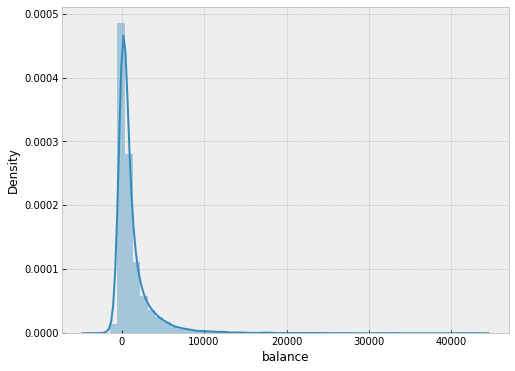

In [ ]:
# train['balance'] の分布を可視化
sns.distplot(train['balance']);

In [ ]:
mu = train['balance'].mean()   # train['balance'] の平均値
sigma = train['balance'].std()   # train['balance'] の標準偏差

# 3σ法で train データを取得
_train = train[(mu - 3 * sigma <= train['balance']) & (train['balance'] <= mu + 3 * sigma)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


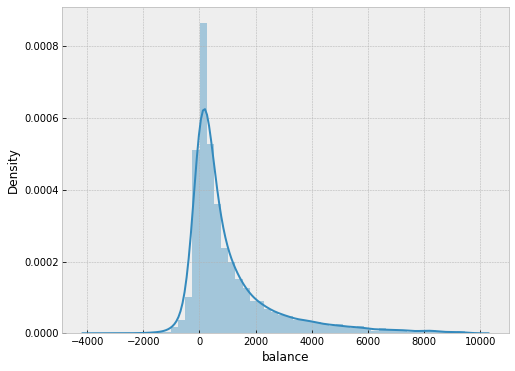

In [ ]:
# 外れ値除去後の分布
sns.distplot(_train['balance']);

In [ ]:
# 元のデータ数と比較
len(train), len(_train)

(6384, 6267)

## **5.　カテゴリカル変数の変換**
### 　One-hot-encording

In [ ]:
# カテゴリカル変数のカラム取得
train_obj = _train.select_dtypes(include='object')
test_obj = test.select_dtypes(include='object')

# カテゴリカル変数の数を確認
print('train のカテゴリカル変数')
print(train_obj.nunique())
print('-------------------------')
print('test のカテゴリカル変数')
print(test_obj.nunique())

train のカテゴリカル変数
job          8
marital      3
education    4
default      2
housing      2
loan         2
poutcome     4
result       2
dtype: int64
-------------------------
test のカテゴリカル変数
job          8
marital      3
education    4
default      2
housing      2
loan         2
poutcome     4
result       2
dtype: int64


In [ ]:
# カテゴリカル変数を One-hotエンコーディング
train_en = pd.get_dummies(_train, columns=['marital', 'default', 'housing', 'loan', 'poutcome', 'result'], drop_first=True)
test_en = pd.get_dummies(test, columns=['marital', 'default', 'housing', 'loan', 'poutcome', 'result'], drop_first=True)

###Label Encoding

In [ ]:
# job, education をLabelエンコーディング

# train_en に対してエンコーディング
encoded = oe.fit_transform(train_en[['job', 'education']].values)
train_en[['job', 'education']] = encoded

# test_en に対してエンコーディング
encoded = oe.fit_transform(test_en[['job', 'education']].values)
test_en[['job', 'education']] = encoded

In [ ]:
# すべてのカラムが数値に変換されているか確認 (train)
train_en.head(3)

,age,job,education,balance,pdays,previous,marital_married,marital_single,default_yes,housing_yes,loan_yes,poutcome_other,poutcome_success,poutcome_unknown,result_success
0,50.0,4.0,1.0,1857,-1.0,0,1,0,0,0,1,0,0,1,0
1,37.0,2.0,1.0,363,-1.0,0,0,1,0,1,0,0,0,1,0
2,35.0,0.0,0.0,422,-1.0,0,1,0,0,1,0,0,0,1,0


In [ ]:
# すべてのカラムが数値に変換されているか確認 (test)
test_en.head(3)

,age,job,education,balance,pdays,previous,marital_married,marital_single,default_yes,housing_yes,loan_yes,poutcome_other,poutcome_success,poutcome_unknown,result_success
0,55.0,4.0,2.0,1810,-1.0,0,1,0,0,1,0,0,0,1,0
1,54.0,3.0,2.0,364,-1.0,0,1,0,0,1,0,0,0,1,0
2,35.0,2.0,1.0,-180,-1.0,0,1,0,0,0,1,0,0,1,1


In [ ]:
# 前処理終了後のデータ
train_en.shape, test_en.shape

((6267, 15), (15000, 15))

# **ニューラルネットワーク**

### **データの準備**
 - 入力値　result_success 以外
 - 目標値　result_success
 - train：val ＝ 8：2
 - バッチサイズ　200

In [ ]:
pl.seed_everything(0)

# 入力値と目標値に分割
x_train = train_en.drop('result_success', axis=1).values
t_train = train_en['result_success'].values
x_test = test_en.drop('result_success', axis=1).values
t_test = test_en['result_success'].values

# PyTorch の Tensor 型へ変換
x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64)

# 入力値と目標値をまとめる
dataset = torch.utils.data.TensorDataset(x_train, t_train)
_dataset = torch.utils.data.TensorDataset(x_test, t_test)

# 各データセットのサンプル数を決定
n_train = int(len(dataset) * 0.9)
n_val = int(len(dataset) - n_train)

# データセットの分割
train, val = torch.utils.data.random_split(dataset, [n_train, n_val])

# バッチサイズの定義
batch_size = 200

# DataLoader に変換
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(_dataset, batch_size)

Global seed set to 0


### **ニューラルネットワークの概要**


ニューラルネットワークの構造
 - 3層構造 
  - 入力層　14ノード
  - 中間層1　1000ノード
  - 中間層2　100ノード
  - 出力層　1ノード



---


活性化関数
 - sigmoid 
  - 一般的に2値分類で利用される

損失関数
 - binary_cross_entropy_with_logits
  - 2値分類で利用される binary_cross_entropy よりも安定

最適化関数
 - RAdam (学習率　0.0005）
  - 収束性、安定性が高い


In [ ]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()

        n1 = 14
        n2 = 1000
        n3 = 100
        self.bn1 = nn.BatchNorm1d(n1)
        self.bn2 = nn.BatchNorm1d(n2)
        self.fc1 = nn.Linear(n1, n2)
        self.fc2 = nn.Linear(n2, n3)
        self.fc3 = nn.Linear(n3, 1)


    def forward(self, x):
        h = self.bn1(x)
        h = F.sigmoid(self.fc1(h))
        h = self.bn2(h)
        h = F.sigmoid(self.fc2(h))
        h = self.fc3(h)
        return h

    # trainデータに対する処理
    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.binary_cross_entropy_with_logits(y, t.unsqueeze(-1).float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(F.sigmoid(y), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss


    # valデータに対する処理
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.binary_cross_entropy_with_logits(y, t.unsqueeze(-1).float())
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(F.sigmoid(y), t), on_step=False, on_epoch=True)
        return loss


    # testデータに対する処理
    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.binary_cross_entropy_with_logits(y, t.unsqueeze(-1).float())
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(F.sigmoid(y), t), on_step=False, on_epoch=True)
        return loss

    # 最適化
    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=0.0005)
        return optimizer

In [ ]:
pl.seed_everything(0)

# インスタンス化
net = Net()

# 学習の実行
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=18, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)

Global seed set to 0
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."

  | Name | Type        | Params
-------------------------------------
0 | bn1  | BatchNorm1d | 28    
1 | bn2  | BatchNorm1d | 2.0 K 
2 | fc1  | Linear      | 15.0 K
3 | fc2  | Linear      | 100 K 
4 | fc3  | Linear      | 101   
-------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.469     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

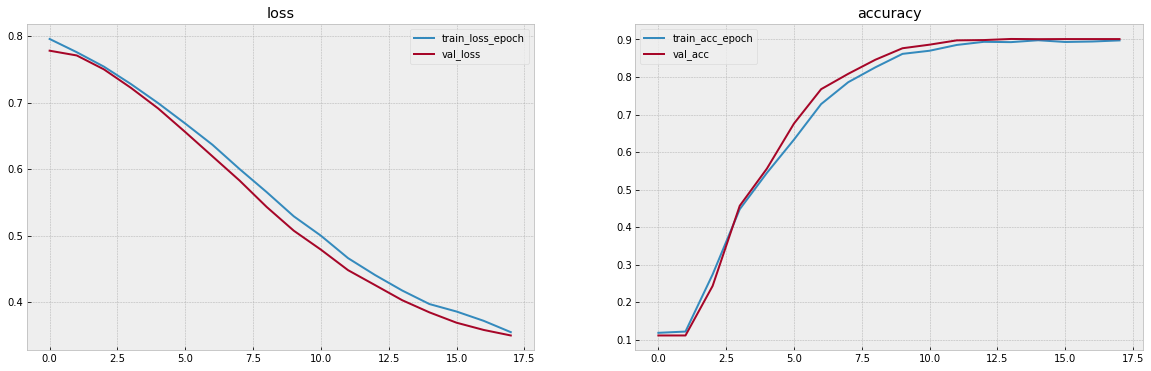

In [ ]:
# 学習ログの取得
log = pd.read_csv('logs/my_exp/version_2/metrics.csv')

plt.figure(figsize=(20,6))

# loss の推移
plt.subplot(1,2,1)
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();
plt.title('loss')
plt.legend()

# accuracy の推移
plt.subplot(1,2,2)
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();
plt.title('accuracy')
plt.legend();

# **テスト用データの検証結果**

In [ ]:
# testデータで検証
trainer.test(test_dataloaders=test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/my_exp/version_1/checkpoints/epoch=17-step=215.ckpt
Loaded model weights from checkpoint at logs/my_exp/version_1/checkpoints/epoch=17-step=215.ckpt


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8921999931335449, 'test_loss': 0.3611408770084381}
--------------------------------------------------------------------------------


[{'test_acc': 0.8921999931335449, 'test_loss': 0.3611408770084381}]

## **accuracy　 89.227 %**
## **loss　0.32639**